<a href="https://colab.research.google.com/github/RGologorsky/fastproj/blob/master/01_notes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
%%time
%%capture
!git clone https://github.com/fastai/fastbook
%cd fastbook
!pip install -r requirements.txt

CPU times: user 57.7 ms, sys: 26.4 ms, total: 84.1 ms
Wall time: 14.2 s


In [0]:
from utils import *

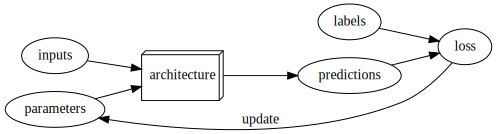

In [7]:
gv('''ordering=in
model[shape=box3d width=1 height=0.7 label=architecture]
inputs->model->predictions; parameters->model; labels->loss; predictions->loss
loss->parameters[constraint=false label=update]''')

# Data (inputs)

## Dataloader

Turns any Python collection into an iterator of batches 
(for GPU).

In [8]:
dl = DataLoader(range(15), bs=5, shuffle=True)
list(dl)

[tensor([ 3, 12,  8, 10,  2]),
 tensor([ 9,  4,  7, 14,  5]),
 tensor([ 1, 13,  0,  6, 11])]

To train a model, use Dataloader of a (x,y) Dataset.

### Useful

- Viz batch: dl.show_batch()
- Get one batch: dl.one_batch(ds_type=1). *Optionally detach (from computational gradient graph) and denorm.*
- Get one item: dl.one_item(). *Optionally detach and denorm.*


one_batch(ds_type:DatasetType=<DatasetType.Train: 1>, detach:bool=True, denorm:bool=True, cpu:bool=True) → Collection[Tensor]
one_item(item, detach:bool=False, denorm:bool=False, cpu:bool=False)


## Dataset

A collection of (x,y) tuples.

In [9]:
ds = L(enumerate(string.ascii_lowercase))
dl = DataLoader(ds, bs=6, shuffle=True)
list(dl)

[(tensor([17, 18, 10, 22,  8, 14]), ('r', 's', 'k', 'w', 'i', 'o')),
 (tensor([20, 15,  9, 13, 21, 12]), ('u', 'p', 'j', 'n', 'v', 'm')),
 (tensor([ 7, 25,  6,  5, 11, 23]), ('h', 'z', 'g', 'f', 'l', 'x')),
 (tensor([ 1,  3,  0, 24, 19, 16]), ('b', 'd', 'a', 'y', 't', 'q')),
 (tensor([2, 4]), ('c', 'e'))]

## Dataloaders

 A class which stores train dl, valid dl (or more).

Access:
- dls.valid, dls.train
- dls.vocab

- Can index directly dls.x[i]
- Can get underlying fname by x.name




## Datablock

A template for building a DataLoaders (or a Datasets). Build data block by answering a list of questions:

**Datablocks**: what are the types of our inputs and targets? *e.g. Images and multiple labels.*

**get_items**: where is the data? *e.g. get_image_files from input path, unneceesary if dataset items already in given input df*

**splitter**: how do we know if a sample (from the items) is in the training or the validation set? *e.g. random, by index, function, df col.* 

**get_x**: how do we get an image (from the items)? *e.g. By looking at column fname; unnecessary if item is already x's fname.*

**get_y**: how do we know the label of an image? *By looking at the column labels.*

**item_tfms**: do we want to apply a function to a given sample? *Yes, we need to resize everything to a given size. RandomResizedCrop(sz, min_scale).* 

**batch_tfms**: do we want to apply a function to a batch after it's created? *Yes, we want data augmentation.*


This gives us this design:


In [0]:
pascal_source = Path(".")

db = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   splitter=ColSplitter(),
                   get_x=ColReader(0, pref=pascal_source/"train"),
                   get_y=ColReader(1, label_delim=' '),
                   item_tfms=Resize(224),
                   batch_tfms=aug_transforms())

In [0]:
def label_func(fname): return "label"

dblock = DataBlock(blocks    = (ImageBlock, CategoryBlock),
                   get_items = get_image_files,
                   get_y     = label_func,
                   splitter  = RandomSplitter(),
                   item_tfms = Resize(224))


Note: For df inputs, most efficient is to avoid iterating over the rows of the df; define get_items to convert df cols into np arrays (from_columns method). 

In [0]:
def _pascal_items(x): return (
    f'{pascal_source}/train/'+x.fname, x.labels.str.split())

df = pd.DataFrame({"is_valid": [True,False]})
valid_idx = df[df['is_valid']].index.values

pascal_db = DataBlock.from_columns(blocks=(ImageBlock, MultiCategoryBlock),
                   get_items=_pascal_items,
                   splitter=IndexSplitter(valid_idx),
                   item_tfms=Resize(224),
                   batch_tfms=aug_transforms())

### Debug:


In [0]:
# db.summary(path/"images", bs=8, show_batch=True, unique=True,...)

# PyToch/Numpy

In [0]:
def print_t_shape(t): print(t.shape, "\n", t)

### Shapes

Tensor of shape:

n: list of *n* elements

(1,n): a list containing 1 list of *n* elements

(n,1): a list containing *n* lists, each of size 1

(x,y): a list containing *x* lists, each of size *y* (or: *x* rows, *y* cols of an image)

(x,y,z): a list containing *x* lists, each of size *y* by *z* (or: batch size/*x* layers of images, each image *y* by *z*)

In [15]:
t = torch.zeros(2,3,4)
print_t_shape(t)

torch.Size([2, 3, 4]) 
 tensor([[[0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.]],

        [[0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.]]])


## Torch.view = np.reshape

view: reshapes the tensor's shape. Special param -1 means "make this dimension as large as needed."


In [16]:
t = torch.zeros((3,4))
print_t_shape(t.view(-1,6))

torch.Size([2, 6]) 
 tensor([[0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.]])


## Stack & Cat

- stack: concatenates sequence of tensors along a new dimension.
- cat: concatenates the given sequence of tensors in the given dimension.

So if A and B are of shape (3, 4): 
- torch.cat([A, B], dim=0) will be of shape (6, 4)
- torch.stack([A, B], dim=0) will be of shape (2, 3, 4)

In [17]:
A = torch.zeros((3,4))
B = torch.ones((3,4))
print_t_shape(A)
print_t_shape(torch.cat([A,B], dim=0))
print_t_shape(torch.stack([A,B], dim=0))

torch.Size([3, 4]) 
 tensor([[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]])
torch.Size([6, 4]) 
 tensor([[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.]])
torch.Size([2, 3, 4]) 
 tensor([[[0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.]],

        [[1., 1., 1., 1.],
         [1., 1., 1., 1.],
         [1., 1., 1., 1.]]])


## Torch.Squeeze & Unsqueeze

- torch.squeeze(input, pos=None, out=None) - removes all dimensions of size 1 (if position given, only acts there)

- torch.unsqueeze(input, pos, out=None) - inserts dimension of size 1 at specified position

In [18]:
t = torch.zeros(1,2)
print_t_shape(t)
print_t_shape(t.unsqueeze(-1))
print_t_shape(t.unsqueeze(-1).squeeze())

torch.Size([1, 2]) 
 tensor([[0., 0.]])
torch.Size([1, 2, 1]) 
 tensor([[[0.],
         [0.]]])
torch.Size([2]) 
 tensor([0., 0.])


In [19]:
print_t_shape(t.unsqueeze(0))
print_t_shape(t.unsqueeze(1))
print_t_shape(t.unsqueeze(2))

torch.Size([1, 1, 2]) 
 tensor([[[0., 0.]]])
torch.Size([1, 1, 2]) 
 tensor([[[0., 0.]]])
torch.Size([1, 2, 1]) 
 tensor([[[0.],
         [0.]]])


## Save model

learn.export() saves architecture, trained parameters, and DataLoaders to "export.pkl".

## Model inference

In [0]:
# learn_inf = load_learner(path/"export.pkl")
# vocab = learn_inf.dls.vocab
# predicted_class, class_index, each_category_probs = learn_inf.predict(fname)

# Implementing Models


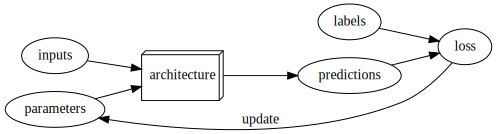

In [21]:
gv('''ordering=in
model[shape=box3d width=1 height=0.7 label=architecture]
inputs->model->predictions; parameters->model; labels->loss; predictions->loss
loss->parameters[constraint=false label=update]''')

## Metrics

Human-interpretable measure of how well predictions match target labels.


L2 penalizes bigger mistakes more heavily than L1 (more lenient with small mistakes).

In [0]:
def L1_norm(x,y): return abs(x-y)
def L2_norm(x,y): return ((x-y)**2).mean().root()

## Loss functions

Computer-optimizable measure of how well predictions match target labels.

### MSE

### Cross-Entropy

### Negative Log Likelihood

## Optimizer

Improve parameter values (minimize loss)

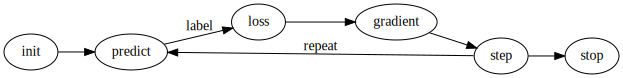

In [26]:
gv('''
init->predict
predict->loss[label=label]
loss->gradient->step->stop
step->predict[label=repeat]
''')

### SGD

### Adam

### Cosine